In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import predictor

np.random.seed(5981)

plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['simsun', 'AR PL UMing CN'],
    'axes.unicode_minus': False,
})

In [2]:
prefix = r'D:\git\zhongguoyuyan\csv'
location = pd.read_csv(os.path.join(prefix, 'dialect', 'location.csv'), index_col=0)

location = location.sample(100)
display(location)

char = pd.read_csv(os.path.join(prefix, 'words.csv'), index_col=0).sample(200)
display(char)

data = predictor.load_data(os.path.join(prefix, 'dialect'), location.index)
data = data[data['iid'].astype(int).isin(char.index)].sample(10000)

,longitude,latitude,insertDate,uploader,firstLevelid,sheetName,filepath,province,city,country,...,population,nation,minorityInfo,dialectInfo,operaInfo,source,degree,area,slice,slices
08K12,120.394904,27.501618,NaN,NaN,08K12,NaN,浙江/苍南闽语需交文件电子版/模板表/其他/概况.xls,浙江,温州,苍南,...,122.89万（2016年常住人口）,汉族119.79万；少数民族有畲族、土家族、苗族、侗族等37个民族，人口合计0.83万人。,（无）,闽南方言，又称浙南闽语，分布于龙港镇、灵溪镇、矾山镇、马站镇、藻溪镇、赤溪镇等；吴语瓯江片，...,苍南渔鼓，流行于讲闽南方言的乡镇，面临濒危；2007年入选第二批浙江省非物质文化遗产保护名录。,yubao,common,闽方言,闽南片,浙南小片
26507,111.871393,26.605054,NaN,NaN,26507,NaN,湖南/祁阳需交文件电子版/模板表/其他/概况.xls,湖南,永州,祁阳,...,全县人口106.56万，其中常住人口86.5万,汉族占99.64%，少数民族0.36%，其中,（无）,祁阳话内部比较统一，但内部也有略微的差异。接近祁东的羊角塘一带口音接近祁东，老派一般将零声母...,主要是祁剧、祁阳小调和渔鼓,yubao,common,NaN,NaN,NaN
05K02,124.666667,41.200000,NaN,NaN,05K02,NaN,辽宁/本溪需交文件电子版/模板表/其他/概况.xls,辽宁,本溪,（无）,...,14.5万（截止2018年底）,汉族11万；满族1.9万；回族1.4万；朝鲜族0.1万；蒙古族：597；锡伯族：155；苗族...,（无）,溪湖区方言没有口音区别,（无）,yubao,common,东北官话区,吉沈片,通溪小片
10G66,119.120000,34.570000,NaN,NaN,10G66,NaN,江苏/连云港#需交文件电子版/模板表/其他/概况.xls,江苏,连云港,海州区,...,户籍人口644029人，常住人口83万多人。,以汉族为主，境内有蒙古族、回族、藏族、维吾尔族、壮族、苗族、朝鲜族、满族、土家族、布依族10...,无少数民族语言,连云港市地处胶辽、中原、江淮三种官话的交界地区，北部赣榆的声母系统具有胶辽官话特点（分尖团、...,淮海戏，清乾隆年间海州一带流行[太平歌]、[猎户腔]，后衍变为说唱民间故事的“打门头词”，因...,yubao,common,NaN,NaN,NaN
15F53,110.716667,21.450000,NaN,NaN,15F53,NaN,广东/吴川需交文件电子版/模板表/其他/概况.xls,广东,湛江,吴川,...,118万（2016年）,汉族，118万（2016年）,据2000年第五次人口普查，吴川现有蒙古族、回族、藏族、苗族、彝族、壮族、满族、布依族、维吾...,吴川市境内有吴川白话、东话、海话；白话有吴阳口音、梅菉口音、塘㙍等口音，吴阳口音人口较多，有...,木鱼歌。,yubao,common,粤方言,高雷片,梅菉白话
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05052,122.150000,39.260000,NaN,NaN,05052,NaN,辽宁/杏树需交文件电子版/模板表/其他/0001调查点概况.xls,辽宁,大连,金州区,...,2.96万,本点主要是汉族人，有一小部分是满族人,（无）,本点只说当地方言，青年人受普通话影响会说地方普通话，具体情况体现在青男、青女相关语料中。,（无）,6fang,common,NaN,NaN,NaN
01019,109.158333,22.241667,NaN,NaN,01019,NaN,广西/灵山檀圩话需交文件电子版/模板表/其他/0001调查点概况.xls,广西,钦州市,灵山县,...,150万,主要民族为汉族，少数民族人口占全县总人口2%左右，其中比较多的少数民族有壮族28840人，瑶...,太平镇某些地区操壮语,主要有粤语、客家话和属于桂南平话的横州话。\n灵山话：灵城、檀圩、新圩、佛子、平山、三海、那...,粤剧、采茶戏、跳岭头、山歌等。,6fang,common,NaN,NaN,NaN
18361,115.462900,27.249753,NaN,NaN,18361,NaN,江西/永丰需交文件电子版/模板表/其他/概况.xls,江西,吉安,永丰,...,50万,汉族495000；畲族5000。,（无）,永丰县方言，以沙溪为界，北面属赣语区，包括恩江、鹿江、坑田、富溪、古县、瑶田、藤田、石马、中...,主要是采茶戏、三角班。其中三角班是由本地民间舞蹈、山歌、说唱等多种形式融合湘剧、赣剧等表演形...,yubao,common,NaN,NaN,NaN
06562,118.281492,37.547960,NaN,NaN,06562,NaN,山东/利津需交文件电子版/模板表/其他/概况.xls,山东,东营,利津,...,28.81,汉族，28.8万,少数民族21个，共一百余人,以利津话为主，陈庄镇靠近寿光的地区方言带有寿光口音，明集乡与沾化靠近，方言带有沾化口音,（无）,yubao,common,官话大区冀鲁官话区,沧惠片,章桓小片


,item,memo
cid,,
660,近,NaN
338,凑,NaN
523,建,NaN
909,吃,NaN
71,箍,～桶，注意声
...,...,...
437,犯,NaN
887,石,NaN
739,厂,NaN


D:\git\sinetym\scripts\zhongguoyuyan\predictor.py:318: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['initial'].fillna('').str.lower() \
D:\git\sinetym\scripts\zhongguoyuyan\predictor.py:342: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['finals'].fillna('').str.lower().str.replace(f'[^{ipa}]', '')
D:\git\sinetym\scripts\zhongguoyuyan\predictor.py:354: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['tone'].fillna('').str.lower().str.replace(f'[^1-5]', '')


In [22]:
dialects = data['oid'].unique()
chars = data['iid'].unique()
initials = data['initial'].unique()

In [3]:
dp = predictor.DialectPredictor(
    dialects,
    chars,
    (initials,),
    emb_size=10,
    target_emb_size=10,
    transform_layer=1,
    transform_size=20,
    target_bias=True,
    emb_l2=0,
    l2=0,
    optimizer=tf.keras.optimizers.Adam(0.02)
)

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(data[['oid', 'iid', 'initial']].values).map(lambda x: (x[:2], x[2:]))
train_dataset = dataset.skip(1000)
test_dataset = dataset.take(1000)

In [5]:
output_prefix = os.path.join(
    'tensorboard',
    'test_predictor',
    datetime.datetime.now().strftime('%Y%m%d%H%M')
)

log_dir = output_prefix
summary_writer = tf.summary.create_file_writer(log_dir)

loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
acc = tf.keras.metrics.Accuracy('acc', dtype=tf.float32)
eval_loss = tf.keras.metrics.Mean('eval_loss', dtype=tf.float32)
eval_acc = tf.keras.metrics.Accuracy('eval_acc', dtype=tf.float32)

checkpoint = tf.train.Checkpoint(
    step=tf.Variable(0),
    dialect_emb=dp.dialect_emb,
    char_emb=dp.char_emb,
    trans_weights=dp.trans_weights,
    att_weighst=dp.att_weights,
    target_embs=dp.target_embs,
    target_biases=dp.target_biases,
    optimizer=dp.optimizer
)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(output_prefix, 'checkpoints'), max_to_keep=1000)

In [54]:
epochs = 20
batch_size = 100

checkpoint.restore(manager.latest_checkpoint)

while checkpoint.step < epochs:
    for inputs, targets in train_dataset.shuffle(10000).batch(batch_size):
        l, target_ids, pred_ids = dp.update(inputs, targets)
        loss.update_state(l)
        acc.update_state(target_ids, pred_ids)

    for inputs, targets in test_dataset.batch(batch_size):
        l, target_ids, pred_ids = dp.loss(inputs, targets)
        eval_loss.update_state(l)
        eval_acc.update_state(target_ids, pred_ids, target_ids < tf.cast(tf.stack([t.shape[0] for t in dp.targets]), tf.int64))
    
    with summary_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=tf.cast(checkpoint.step, tf.int64))
            tf.summary.scalar('acc', acc.result(), step=tf.cast(checkpoint.step, tf.int64))
            tf.summary.scalar('eval_loss', eval_loss.result(), step=tf.cast(checkpoint.step, tf.int64))
            tf.summary.scalar('eval_acc', eval_acc.result(), step=tf.cast(checkpoint.step, tf.int64))
            
    loss.reset_states()
    acc.reset_states()
    eval_loss.reset_states()
    eval_acc.reset_states()

    checkpoint.step.assign_add(1)
    manager.save()

In [55]:
steps = []
dialect_embs = []
char_embs = []
dest_embs = []
target_embs = [list() for _ in dp.target_embs]

for ckpt in manager.checkpoints:
    checkpoint.restore(ckpt)
    steps.append(checkpoint.step.numpy())
    dialect_embs.append(dp.dialect_emb.numpy())
    char_embs.append(dp.char_emb.numpy())
    dest_embs.append(dp.transform(dp.get_dialect_emb(data['oid'].values), dp.get_char_emb(data['iid'].values)).numpy())
    for i, e in enumerate(dp.target_embs):
        target_embs[i].append(e.numpy())
    
steps = np.stack(steps)
dialect_embs = np.stack(dialect_embs)
char_embs = np.stack(char_embs)
dest_embs = np.stack(dest_embs)
target_embs = [np.stack(e) for e in target_embs]

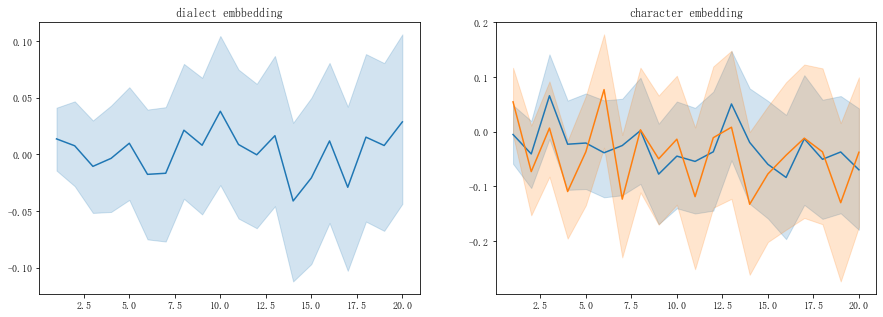

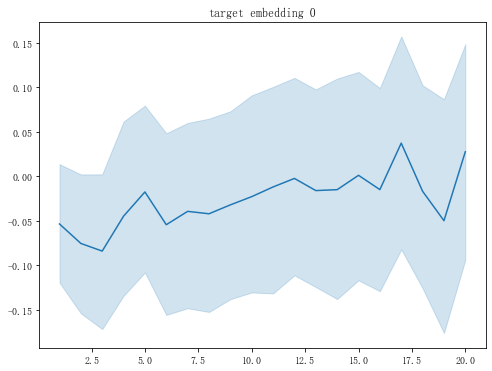

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

x = np.repeat(steps, dialect_embs.shape[1] * dialect_embs.shape[2])
y = dialect_embs.flatten()
if x.shape[0] > 10000:
    idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
    x = x[idx]
    y = y[idx]
    
sns.lineplot(x=x, y=y, ax=ax1)
ax1.set_title('dialect embbedding')

x = np.repeat(steps, char_embs.shape[1] * char_embs.shape[2])
y = char_embs.flatten()
idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
sns.lineplot(x=x[idx], y=y[idx], ax=ax2)

x = np.repeat(steps, dest_embs.shape[1] * dest_embs.shape[2])
y = dest_embs.flatten()
idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
sns.lineplot(x=x[idx], y=y[idx], ax=ax2)
ax2.set_title('character embedding')

plt.show()

fig, axes = plt.subplots(len(target_embs), 1, squeeze=False)
fig.set_size_inches(8, 6 * len(target_embs))

for i, emb in enumerate(target_embs):
    x = np.repeat(steps, emb.shape[1] * emb.shape[2])
    y = emb.flatten()
    if x.shape[0] > 10000:
        idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
        x = x[idx]
        y = y[idx]
        
    sns.lineplot(x=x, y=y, ax=axes[i, 0])
    axes[i, 0].set_title('target embedding {}'.format(i))
    
plt.show()

In [57]:
dialect_emb = dp.dialect_emb.numpy()
dialect_pca = PCA(2).fit(dialect_emb)
dialect_pc = dialect_pca.transform(dialect_emb)
char_emb = dp.char_emb.numpy()
char_pca = PCA(2).fit(char_emb)
char_pc = char_pca.transform(char_emb)

initial_emb = dp.target_embs[0].numpy()
initial_pc = char_pca.transform(initial_emb[:, :10])
initial_dialect_pc = dialect_pca.transform(initial_emb[:, :10])

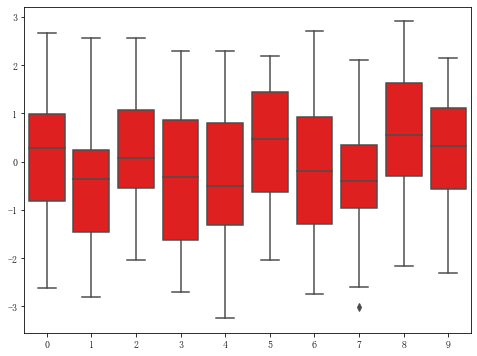

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=initial_emb, color='red')
plt.show()

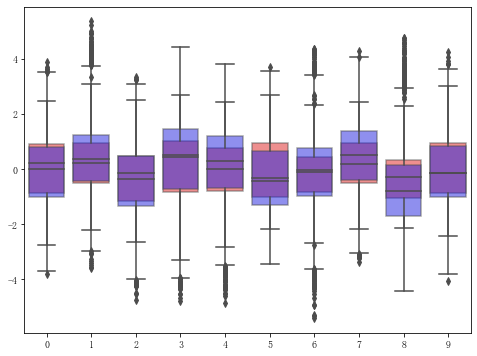

In [11]:
dest_emb = dp.transform(dp.get_dialect_emb(data['oid'].values), dp.get_char_emb(data['iid'].values))

plt.figure(figsize=(8, 6))
sns.boxplot(data=char_emb, color='red', boxprops={'alpha': 0.5})
sns.boxplot(data=dest_emb, color='blue', boxprops={'alpha': 0.5})
plt.show()

ValueError: Input `data` can have no more than 2 dimensions

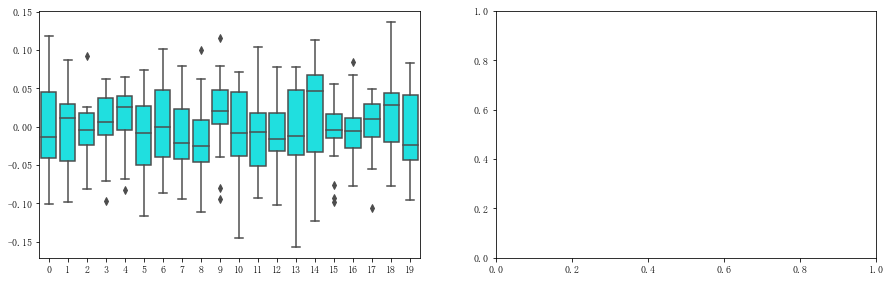

In [12]:
for aw, tw in zip(dp.att_weights, dp.trans_weights):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.boxplot(data=aw.numpy().T, color='cyan')
    plt.subplot(2, 2, 2)
    sns.boxplot(data=tw.numpy(), color='cyan')
    plt.subplot(2, 2, 3)
    sns.boxplot(data=tw.numpy().T, color='cyan')
    plt.show()

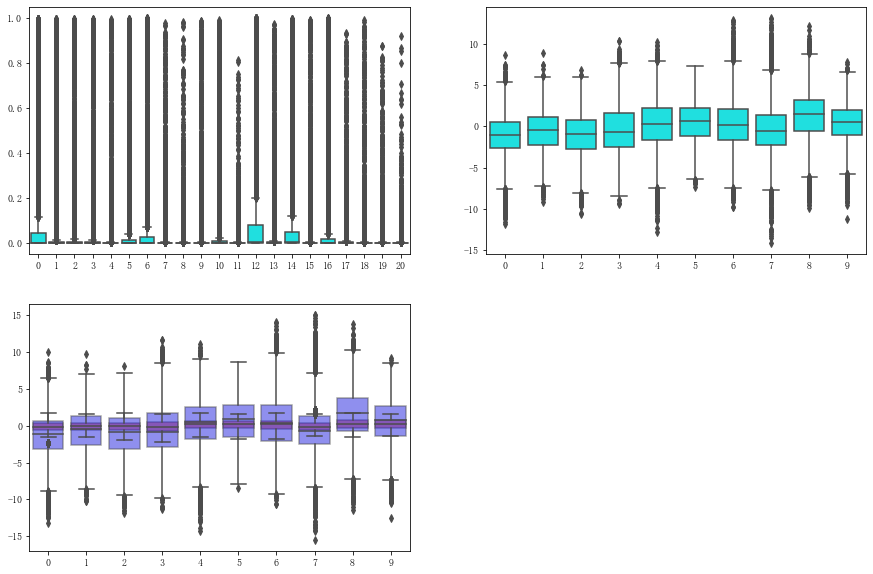

In [13]:
input_dialect_emb = dp.get_dialect_emb(data['oid'])
emb = dp.get_char_emb(data['iid'])
for aw, tw in zip(dp.att_weights, dp.trans_weights):
    x = tf.concat([input_dialect_emb, emb], axis=1)
    att = dp.activation(tf.matmul(x, aw))
    trans = tf.tensordot(x, tw, axes=[1, 0])
    trans = tf.reshape(tf.matmul(att[:, None, :-1], trans), [-1, emb.shape[1]])
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.boxplot(data=att.numpy(), color='cyan')
    plt.subplot(2, 2, 2)
    sns.boxplot(data=trans.numpy(), color='cyan')
    plt.subplot(2, 2, 3)
    sns.boxplot(data=emb.numpy(), color='red', boxprops={'alpha': 0.5})
    emb += trans
    sns.boxplot(data=emb.numpy(), color='blue', boxprops={'alpha': 0.5})
    plt.show()

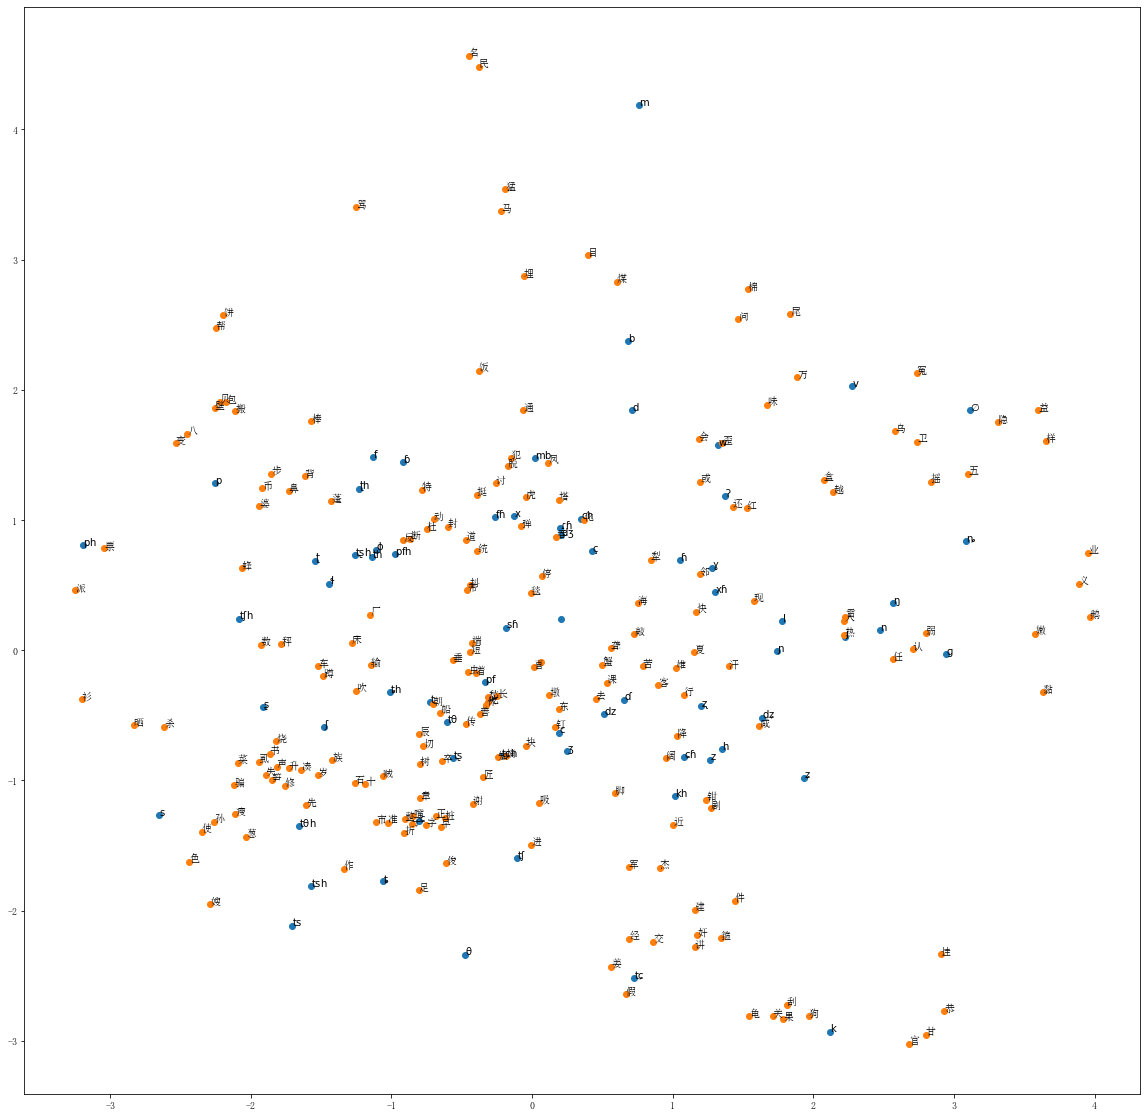

In [12]:
plt.figure(figsize=(20, 20))
    
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.scatter(char_pc[:, 0], char_pc[:, 1])
for i, cid in enumerate(dp.chars.numpy().astype(int)):
    plt.annotate(char.loc[cid, 'item'], xy=(char_pc[i, 0], char_pc[i, 1]))

plt.show()

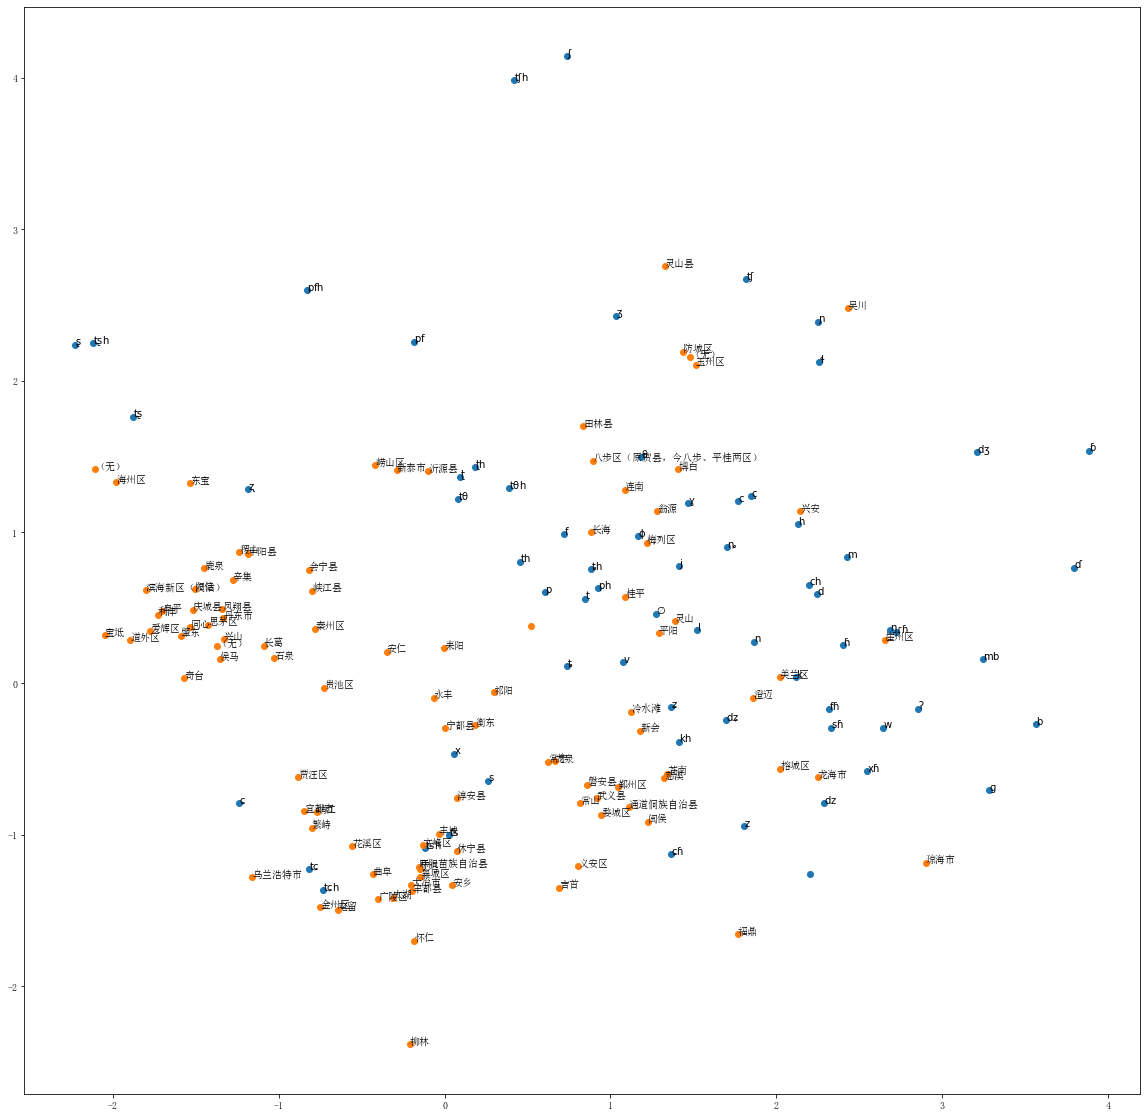

In [13]:
plt.figure(figsize=(20, 20))
    
plt.scatter(initial_dialect_pc[:, 0], initial_dialect_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_dialect_pc[i, 0], initial_dialect_pc[i, 1]))
    
plt.scatter(dialect_pc[:, 0], dialect_pc[:, 1])
for i, oid in enumerate(np.char.decode(dp.dialects.numpy().astype(np.bytes_))):
    plt.annotate(location.loc[oid, 'country'], xy=(dialect_pc[i, 0], dialect_pc[i, 1]))

plt.show()

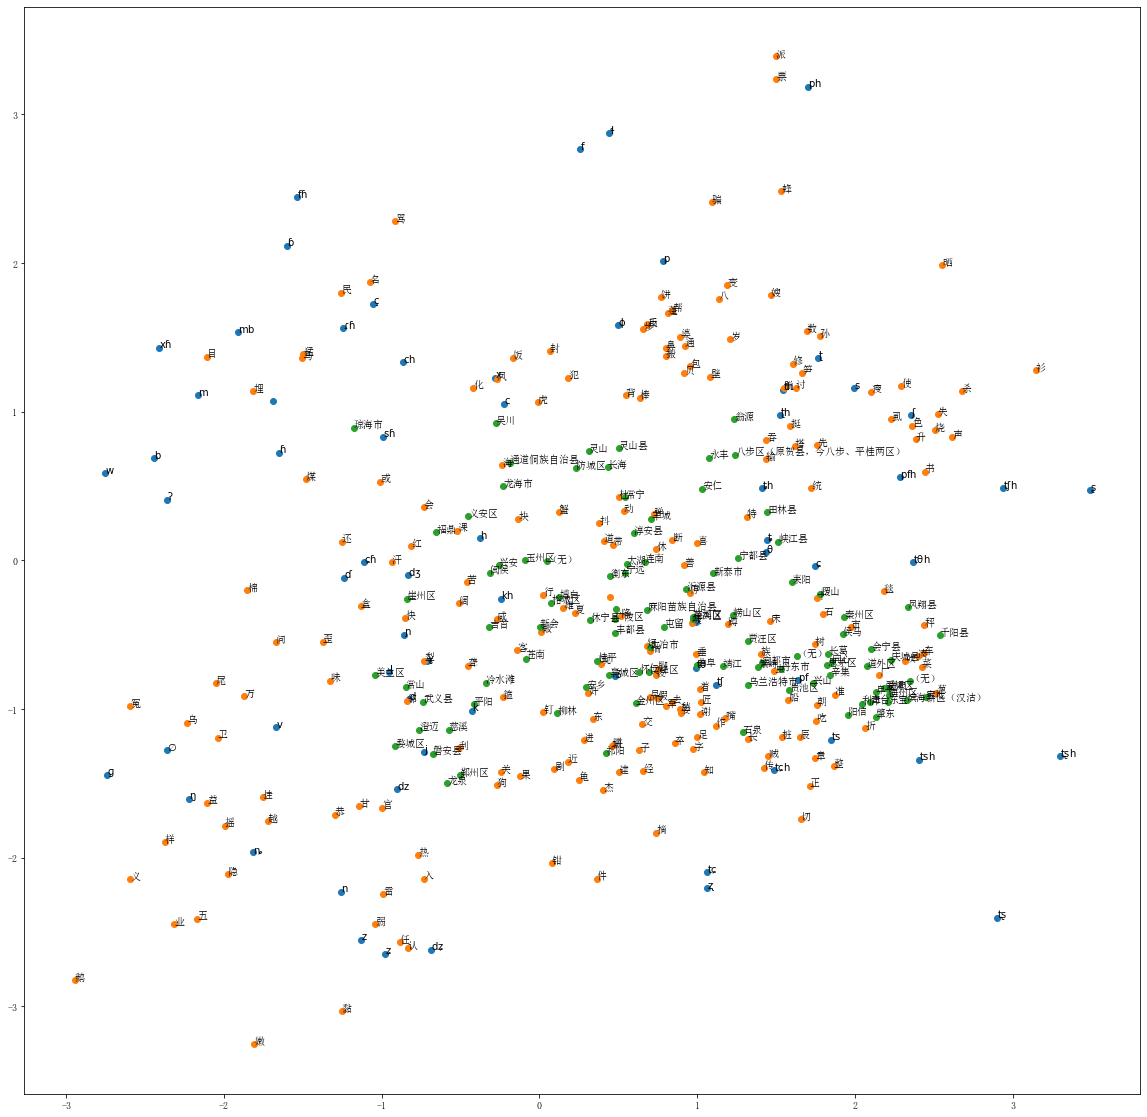

In [14]:
initial_pca = PCA(2).fit(initial_emb)
initial_pc = initial_pca.transform(initial_emb)
char_initial_pc = initial_pca.transform(char_emb)
dialect_initial_pc = initial_pca.transform(dialect_emb)

plt.figure(figsize=(20, 20))
    
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.scatter(char_initial_pc[:, 0], char_initial_pc[:, 1])
for i, cid in enumerate(dp.chars.numpy().astype(int)):
    plt.annotate(char.loc[cid, 'item'], xy=(char_initial_pc[i, 0], char_initial_pc[i, 1]))
    
plt.scatter(dialect_initial_pc[:, 0], dialect_initial_pc[:, 1])
for i, oid in enumerate(np.char.decode(dp.dialects.numpy().astype(np.bytes_))):
    plt.annotate(location.loc[oid, 'country'], xy=(dialect_initial_pc[i, 0], dialect_initial_pc[i, 1]))

plt.show()

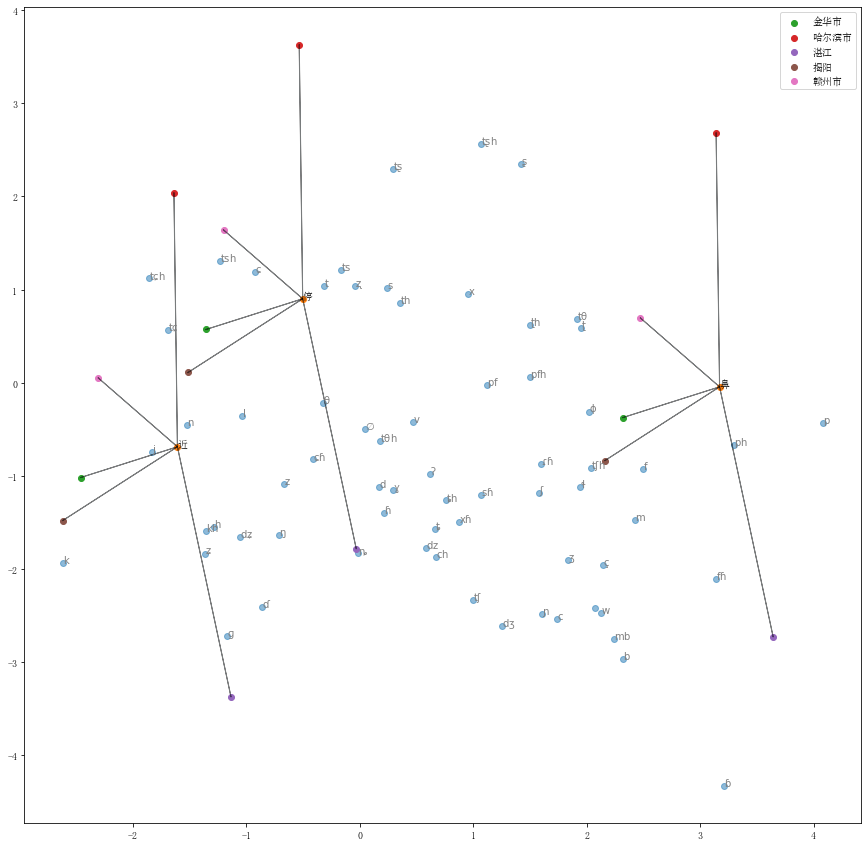

In [58]:
test_dialect = np.asarray(['08K18', '25381', '15F53', '15230', '18359'])
# test_dialect = np.asarray(['08K18', '25381', '15230', '18359'])
test_char = np.asarray(['0660', '0894', '0214'])
test_dialect_emb = dp.get_dialect_emb(test_dialect)
test_char_emb = dp.get_char_emb(test_char)
dest_emb = dp.transform(tf.repeat(test_dialect_emb, test_char_emb.shape[0], axis=0), tf.tile(test_char_emb, [test_dialect_emb.shape[0], 1]))
pca = PCA(2).fit(tf.concat([test_char_emb, dest_emb], axis=0))
test_char_pc = pca.transform(test_char_emb)
dest_pc = pca.transform(dest_emb).reshape(test_dialect.shape[0], test_char.shape[0], -1)

test_initial_pc = pca.transform(initial_emb)

plt.figure(figsize=(15, 15))

plt.scatter(test_initial_pc[:, 0], test_initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(initials):
    plt.annotate(f'$\mathrm{{{initial}}}$', xy=(test_initial_pc[i, 0], test_initial_pc[i, 1]), color='gray')
    
plt.scatter(test_char_pc[:, 0], test_char_pc[:, 1])
for i, cid in enumerate(test_char):
    plt.annotate(char.loc[int(cid), 'item'], xy=(test_char_pc[i, 0], test_char_pc[i, 1]))
    
for i in range(dest_pc.shape[0]):
    plt.scatter(dest_pc[i, :, 0], dest_pc[i, :, 1], label=location.loc[test_dialect[i], 'city'])
    
    for j in range(dest_pc.shape[1]):
        plt.arrow(test_char_pc[j, 0], test_char_pc[j, 1], dest_pc[i, j, 0] - test_char_pc[j, 0], dest_pc[i, j, 1] - test_char_pc[j, 1], alpha=0.5)

plt.legend()
plt.show()

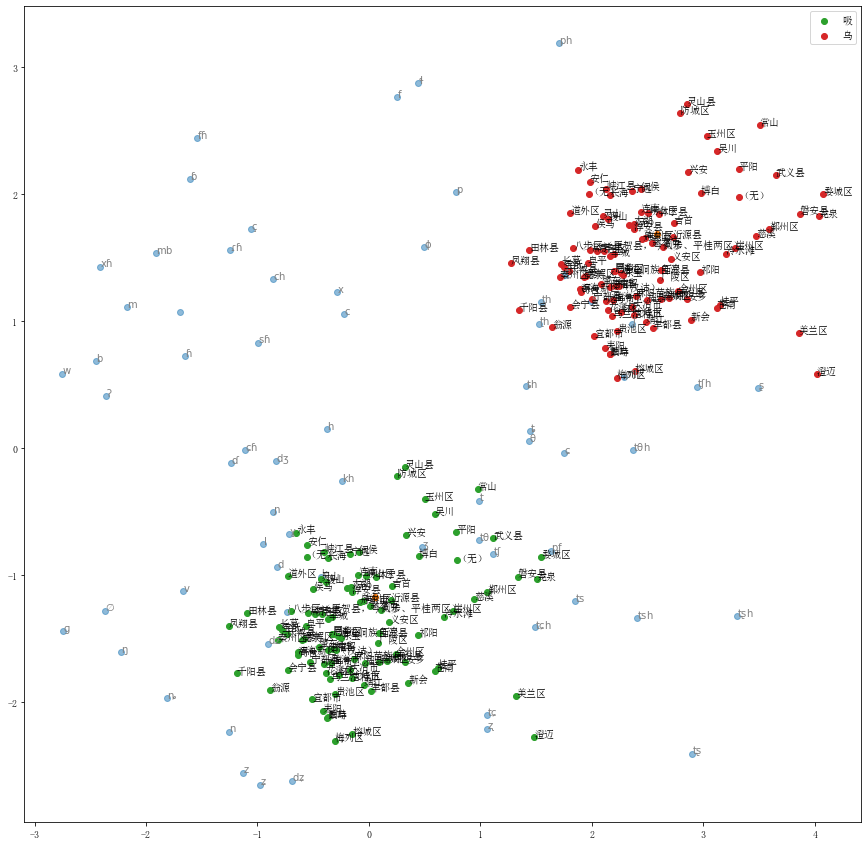

In [15]:
dest_emb = dp.transform(
    tf.repeat(dp.dialect_emb[:-1], 2, axis=0),
    tf.tile(dp.char_emb[:2], [dp.dialect_emb.shape[0] - 1, 1])
).numpy()
char_pc = char_pca.transform(char_emb)
dest_pc = char_pca.transform(dest_emb).reshape(-1, 2, 2)
dialects = np.char.decode(dp.dialects[:-1].numpy().astype(np.bytes_))
chars = char.loc[dp.chars[:2].numpy().astype(int), 'item'].values

plt.figure(figsize=(15, 15))

plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]), color='gray')

plt.scatter(char_pc[:2, 0], char_pc[:2, 1])

for i in range(dest_pc.shape[1]):
    plt.scatter(dest_pc[:, i, 0], dest_pc[:, i, 1], label=chars[i])
    for j in range(dialects.shape[0]):
        plt.annotate(location.loc[dialects[j], 'country'], xy=(dest_pc[j, i, 0], dest_pc[j, i, 1]))

plt.legend()
plt.show()

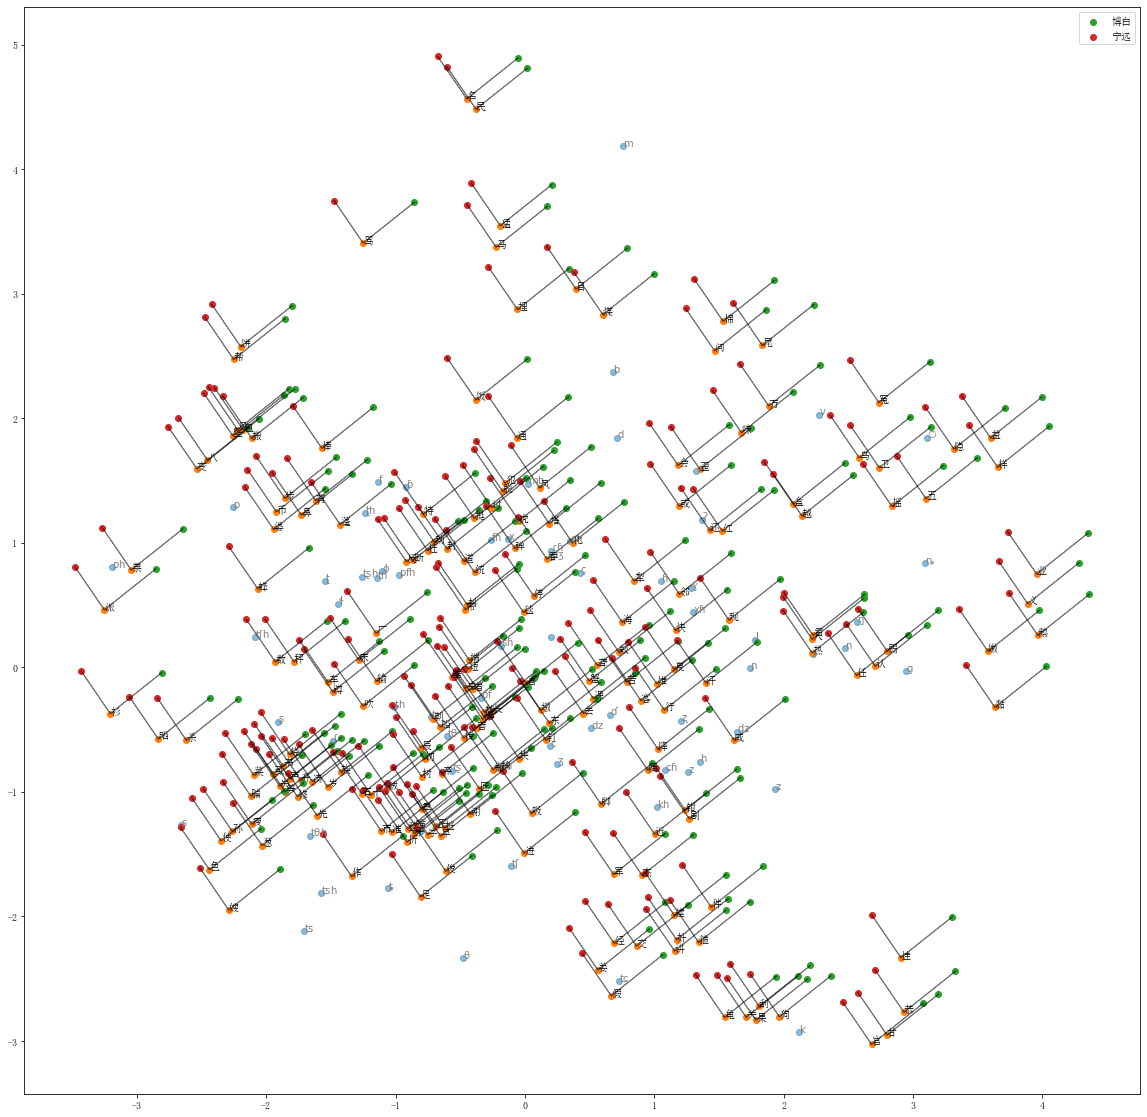

In [27]:
dest_emb = dp.transform(
    tf.repeat(dp.dialect_emb[:2], dp.char_emb.shape[0] - 1, axis=0),
    tf.tile(dp.char_emb[:-1], [2, 1])
).numpy()

dest_pc = char_pca.transform(dest_emb).reshape([2, -1, 2])

plt.figure(figsize=(20, 20))

plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(initials):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]), color='gray')
    
plt.scatter(char_pc[:-1, 0], char_pc[:-1, 1])
for i in range(chars.shape[0]):
    plt.annotate(char.loc[int(chars[i]), 'item'], xy=(char_pc[i, 0], char_pc[i, 1]))

for i in range(dest_pc.shape[0]):
    plt.scatter(dest_pc[i, :, 0], dest_pc[i, :, 1], label=location.loc[dialects[i], 'country'])
    
    for j in range(dest_pc.shape[1]):
        plt.arrow(char_pc[j, 0], char_pc[j, 1], dest_pc[i, j, 0] - char_pc[j, 0], dest_pc[i, j, 1] - char_pc[j, 1], alpha=0.5)
        
plt.legend()
plt.show()

In [41]:
test_dialects = ['05K02', '23C85']
test_chars = ['0469', '0474', '0656']
demb = dp.get_dialect_emb(test_dialects)
cemb = dp.get_char_emb(test_chars)
emb = dp.transform(tf.repeat(demb, cemb.shape[0], axis=0), tf.tile(cemb, [demb.shape[0], 1]))
dest_emb = emb[0::3] - emb[1::3] + emb[2::3]
pred = np.char.decode(tf.stack(
    [dp.id_to_target(i, tf.argmax(tf.matmul(dest_emb, e, transpose_b=True), axis=1)) for i, e in enumerate(dp.target_embs)]
    , axis=1
).numpy().astype(np.bytes_))
display(pred)

array([['k'],
       ['k']], dtype='<U1')

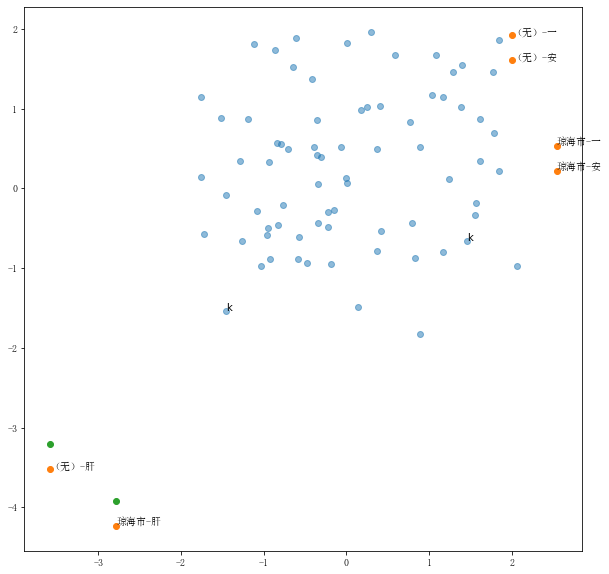

In [42]:
plt.figure(figsize=(10, 10))
plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
src_pc = char_pca.transform(emb)
dest_pc = char_pca.transform(dest_emb)
plt.scatter(src_pc[:, 0], src_pc[:, 1])
plt.scatter(dest_pc[:, 0], dest_pc[:, 1])

for i in range(src_pc.shape[0]):
    plt.annotate(
        '{}-{}'.format(location.loc[test_dialects[i // 3], 'country'], char.loc[int(test_chars[i % 3]), 'item']),
        xy=(src_pc[i, 0], src_pc[i, 1])
    )
    
initial_id = dp.target_to_id(0, pred[:, 0]).numpy()
for i in range(initial_id.shape[0]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(pred[i, 0]), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.show()

In [43]:
demb = dp.get_dialect_emb(['05K02', '08K18'])
demb1 = demb[0]
demb2 = demb[1]
cemb = dp.get_char_emb(['0843'])[0]
w = np.arange(0, 1.1, 0.1)
demb = (1 - w[:, None]) * demb1[None, :] + w[:, None] * demb2[None, :]
emb = dp.transform(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
pred = dp.predict_id_emb(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
display(np.char.decode(tf.stack([dp.id_to_target(i, pred[:, i]) for i in range(pred.shape[1])], axis=1).numpy().astype(np.bytes_)))

array([['p'],
       ['p'],
       ['p'],
       ['p'],
       ['p'],
       ['p'],
       ['b'],
       ['b'],
       ['b'],
       ['b'],
       ['b']], dtype='<U1')

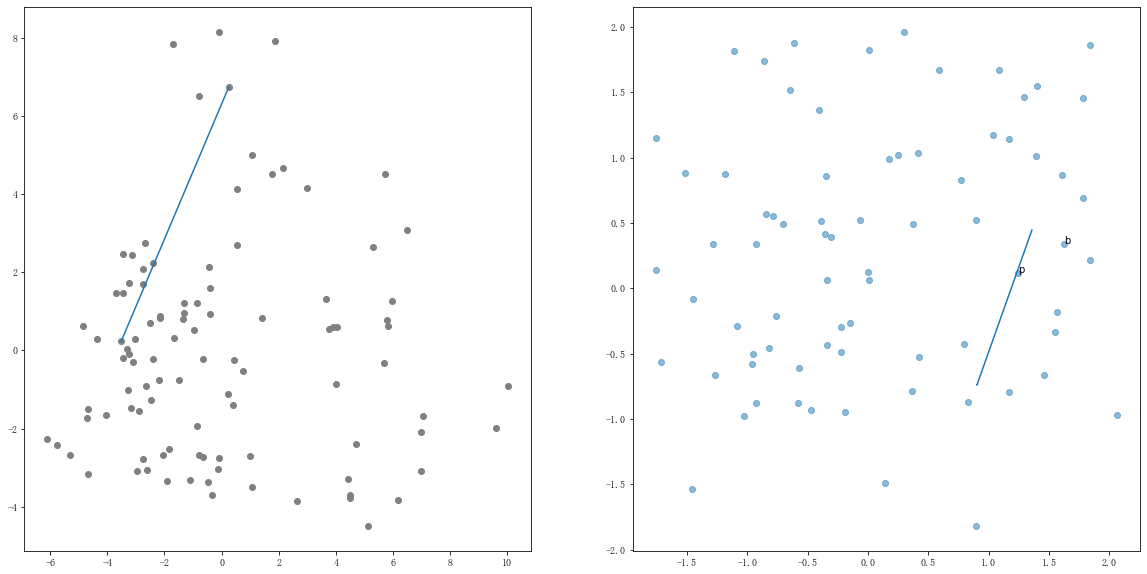

In [44]:
dialect_pca = PCA(2)
dialect_pc = dialect_pca.fit_transform(dialect_emb)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax1.scatter(dialect_pc[:, 0], dialect_pc[:, 1], color='gray')
src_pc = dialect_pca.transform(demb.numpy())
ax1.plot(src_pc[:, 0], src_pc[:, 1])

ax2.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
dest_pc = char_pca.transform(emb)
ax2.plot(dest_pc[:, 0], dest_pc[:, 1])

ids = tf.unique(pred[:, 0])[0]
phones = np.char.decode(dp.id_to_target(0, ids).numpy().astype(np.bytes_))
for id, phone in zip(ids.numpy(), phones):
    ax2.annotate(r'$\mathrm{{{}}}$'.format(phone), xy=(initial_pc[id, 0], initial_pc[id, 1]))
    
plt.show()